# Image Super-Resolution with Efficien Sub-Pixel CNN

#### Setup

In [5]:
import tensorflow as tf
import os
import math
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

In [7]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70778880/70763455 [==============================] - 57s 1us/step


In [9]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


2022-04-14 10:38:08.921747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-14 10:38:08.921792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-14 10:38:08.921825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (3800411-Latitude-E7270): /proc/driver/nvidia/version does not exist
2022-04-14 10:38:08.922219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def scaling( input_image ):
    return input_image / 255.0

Scales the whole sets

In [11]:
train_ds = train_ds.map( scaling )
valid_ds = valid_ds.map( scaling )

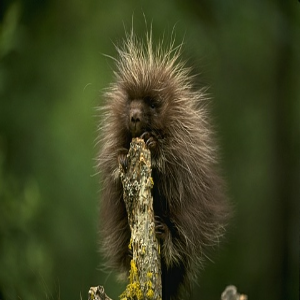

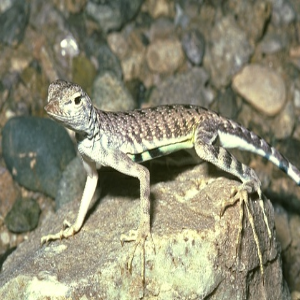

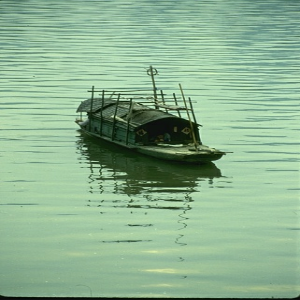

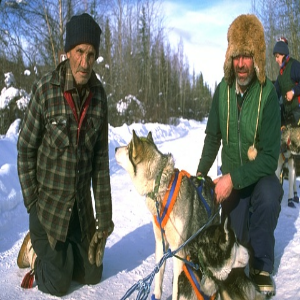

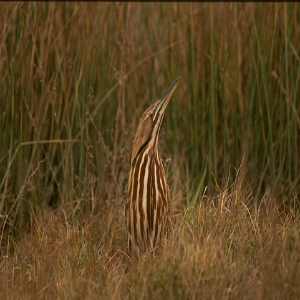

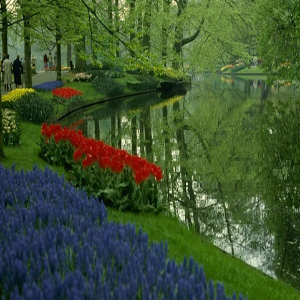

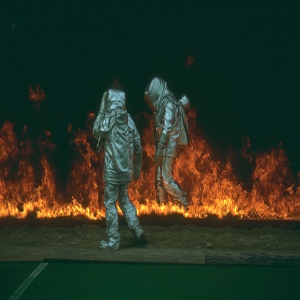

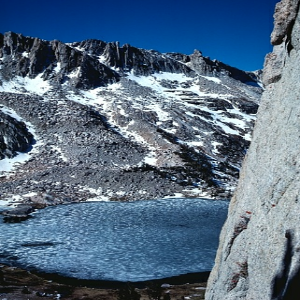

In [12]:
for batch in train_ds.take(1):
    for img in batch:
            display( array_to_img( img ) )

Resize & Crop images

In [15]:
dataset = os.path.join( root_dir, "images" )
test_path = os.path.join( dataset, "test" )

test_img_paths = sorted( 
    [
        os.path.join( test_path, fname )
        for fname in os.listdir( test_path )
        if fname.endswith(".jpg")
    ]
)

In [17]:
def process_input( input, input_size, upscale_factor ):
    input = tf.image.rgb_to_yuv( input )
    last_dimension_axis = len( input.shape ) - 1
    y, u, v = tf.split( input, 3, axis=last_dimension_axis )
    return tf.image.resize( y, [input_size, input_size], method="area" )

In [20]:
def process_target( input ):
    input = tf.image.rgb_to_yuv( input )
    last_dimension_axis = len( input.shape ) - 1
    y, u, v = tf.split( input, 3, axis=last_dimension_axis )
    return y 

In [21]:
train_ds = train_ds.map(
        lambda x: (process_input( x, input_size, upscale_factor ), process_target( x ))
)
train_ds = train_ds.prefetch( buffer_size=32 )

In [22]:
valid_ds = valid_ds.map(
        lambda x: (process_input( x, input_size, upscale_factor ), process_target( x ))
)
valid_ds = valid_ds.prefetch( buffer_size=32 )

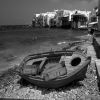

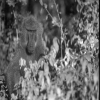

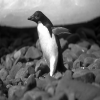

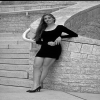

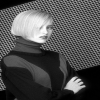

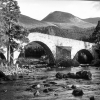

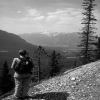

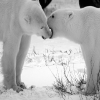

In [23]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display( array_to_img( img ) )

In [32]:
def get_model( upscale_factor=3, channels=3 ):
    conv_args = {
        "activation": "relu",
        "kernel_initializer" : "Orthogonal",
        "padding" : "same"
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)
    
    return keras.Model(inputs, outputs)

Utility functions

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [34]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [35]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 64)    1664      
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_6 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

### Train the model

Mean PSNR for epoch: 24.77


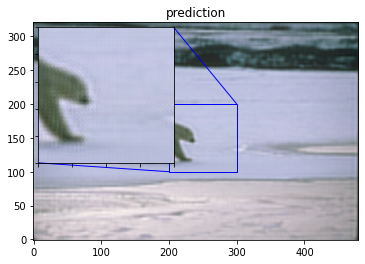

Mean PSNR for epoch: 25.76
Mean PSNR for epoch: 26.32
Mean PSNR for epoch: 26.06
Mean PSNR for epoch: 26.31
Mean PSNR for epoch: 26.31
Mean PSNR for epoch: 26.14
Mean PSNR for epoch: 26.31
Mean PSNR for epoch: 26.23
Mean PSNR for epoch: 26.36
Mean PSNR for epoch: 26.09
Mean PSNR for epoch: 26.28
Mean PSNR for epoch: 26.44
Mean PSNR for epoch: 26.40
Mean PSNR for epoch: 26.26
Mean PSNR for epoch: 25.91
Mean PSNR for epoch: 26.45
Mean PSNR for epoch: 26.81
Mean PSNR for epoch: 26.62
Mean PSNR for epoch: 26.56
Mean PSNR for epoch: 25.47


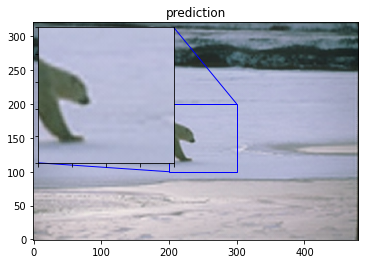

Mean PSNR for epoch: 26.63
Mean PSNR for epoch: 26.70
Mean PSNR for epoch: 27.05
Mean PSNR for epoch: 26.20
Mean PSNR for epoch: 27.17
Mean PSNR for epoch: 26.54
Mean PSNR for epoch: 26.58
Mean PSNR for epoch: 26.41
Mean PSNR for epoch: 26.15
Mean PSNR for epoch: 26.51
Mean PSNR for epoch: 26.94
Mean PSNR for epoch: 26.51
Mean PSNR for epoch: 26.69
Mean PSNR for epoch: 26.87
Mean PSNR for epoch: 26.20
Mean PSNR for epoch: 26.76
Mean PSNR for epoch: 26.69
Mean PSNR for epoch: 26.38
Mean PSNR for epoch: 26.32
Mean PSNR for epoch: 26.70


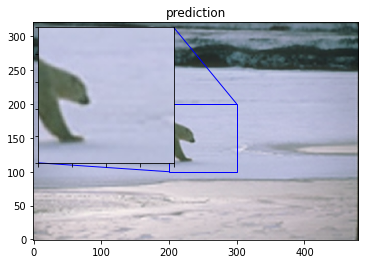

Mean PSNR for epoch: 26.85
Mean PSNR for epoch: 26.86
Mean PSNR for epoch: 26.48
Mean PSNR for epoch: 26.28
Mean PSNR for epoch: 26.58
Mean PSNR for epoch: 26.33
Mean PSNR for epoch: 25.63
Mean PSNR for epoch: 26.41
Mean PSNR for epoch: 26.73
Mean PSNR for epoch: 26.47
Mean PSNR for epoch: 26.92
Mean PSNR for epoch: 26.64
Mean PSNR for epoch: 26.91
Mean PSNR for epoch: 26.79
Mean PSNR for epoch: 26.65
Mean PSNR for epoch: 26.35
Mean PSNR for epoch: 26.82
Mean PSNR for epoch: 26.44
Mean PSNR for epoch: 26.77
Mean PSNR for epoch: 26.28


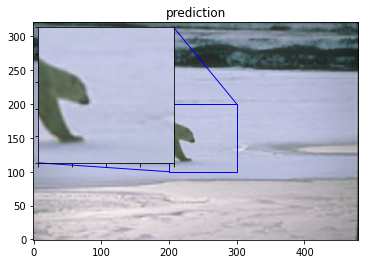

Mean PSNR for epoch: 26.38
Mean PSNR for epoch: 27.33
Mean PSNR for epoch: 26.88
Mean PSNR for epoch: 26.36
Mean PSNR for epoch: 26.65
Mean PSNR for epoch: 26.68
Mean PSNR for epoch: 26.19
Mean PSNR for epoch: 26.73
Mean PSNR for epoch: 26.73
Mean PSNR for epoch: 26.87
Mean PSNR for epoch: 26.73
Mean PSNR for epoch: 26.54
Mean PSNR for epoch: 26.44
Mean PSNR for epoch: 26.43
Mean PSNR for epoch: 26.53
Mean PSNR for epoch: 26.92
Mean PSNR for epoch: 26.94
Mean PSNR for epoch: 27.02
Mean PSNR for epoch: 26.91
Mean PSNR for epoch: 26.65


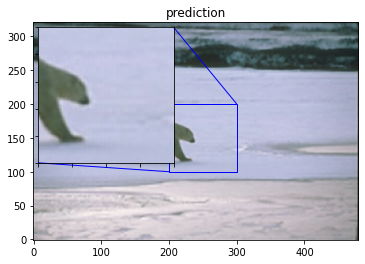

Mean PSNR for epoch: 26.85
Mean PSNR for epoch: 26.71
Mean PSNR for epoch: 26.86
Mean PSNR for epoch: 26.18
Mean PSNR for epoch: 26.52
Mean PSNR for epoch: 26.39
Mean PSNR for epoch: 26.59
Mean PSNR for epoch: 26.38
Mean PSNR for epoch: 26.33
Mean PSNR for epoch: 26.85
Mean PSNR for epoch: 26.89
Mean PSNR for epoch: 26.61
Mean PSNR for epoch: 26.34
Mean PSNR for epoch: 26.48
Mean PSNR for epoch: 26.43
Mean PSNR for epoch: 26.35
Mean PSNR for epoch: 26.59
Mean PSNR for epoch: 27.13
Mean PSNR for epoch: 26.39


In [38]:
epochs = 100
model.compile( optimizer=optimizer, loss=loss_fn )
model.fit( train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=0 )
model.load_weights( checkpoint_filepath )

PSNR of low resolution image and high resolution image is 29.8502
PSNR of predict and high resolution is 30.4320


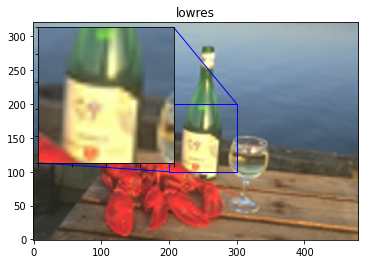

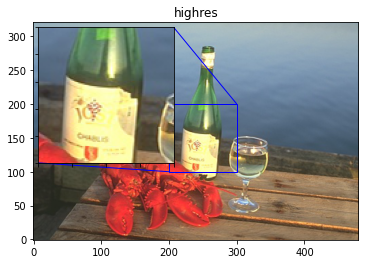

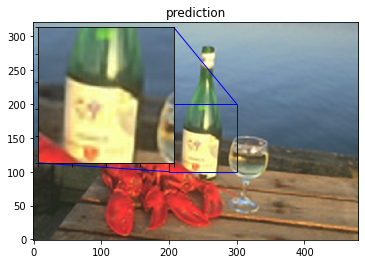

PSNR of low resolution image and high resolution image is 24.9783
PSNR of predict and high resolution is 26.0069


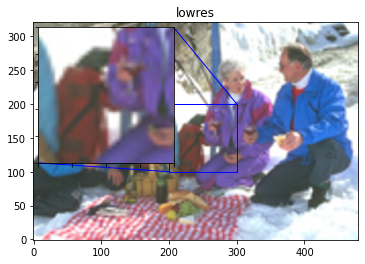

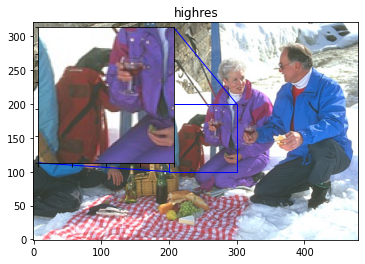

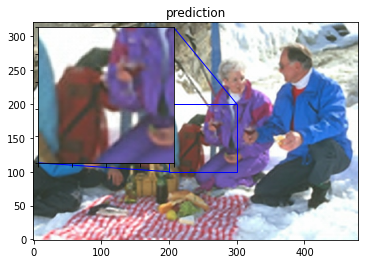

PSNR of low resolution image and high resolution image is 27.7724
PSNR of predict and high resolution is 28.3639


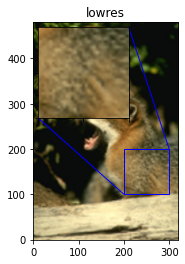

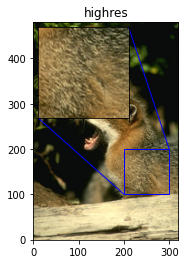

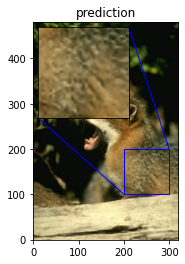

PSNR of low resolution image and high resolution image is 28.0314
PSNR of predict and high resolution is 28.3005


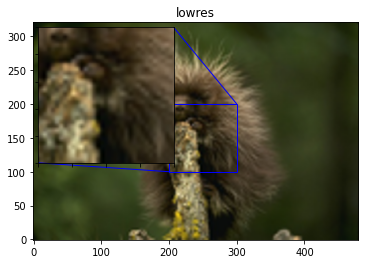

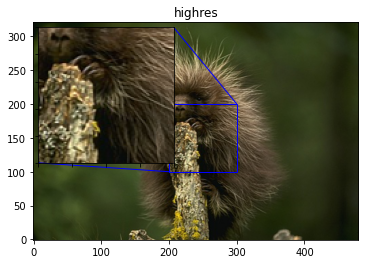

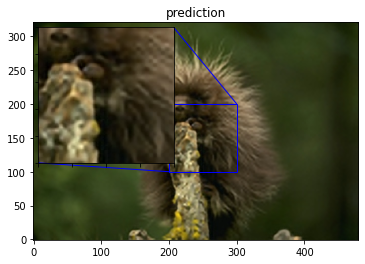

PSNR of low resolution image and high resolution image is 25.7630
PSNR of predict and high resolution is 26.3684


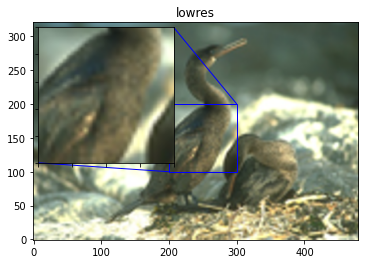

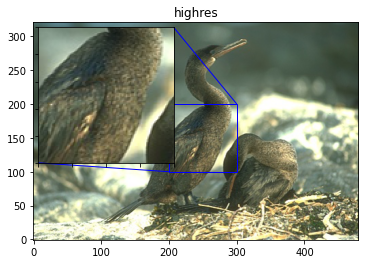

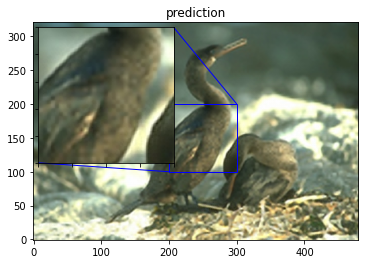

PSNR of low resolution image and high resolution image is 25.7874
PSNR of predict and high resolution is 26.5831


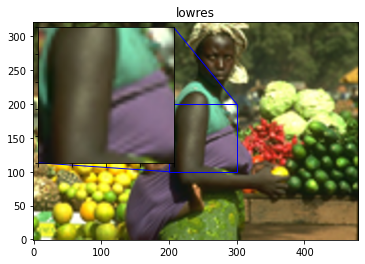

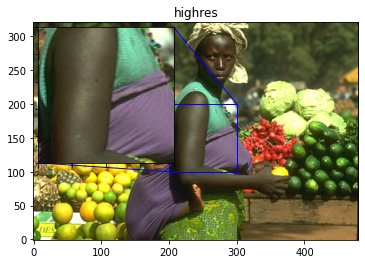

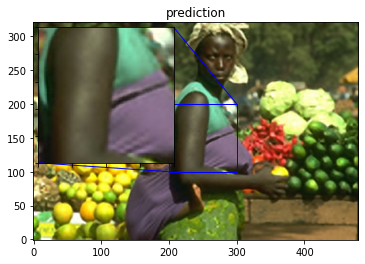

PSNR of low resolution image and high resolution image is 26.2512
PSNR of predict and high resolution is 27.1717


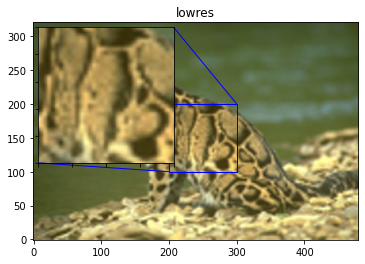

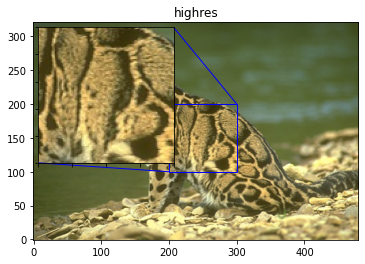

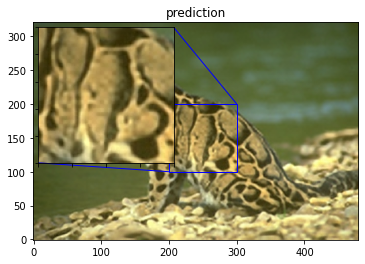

PSNR of low resolution image and high resolution image is 23.3820
PSNR of predict and high resolution is 24.8075


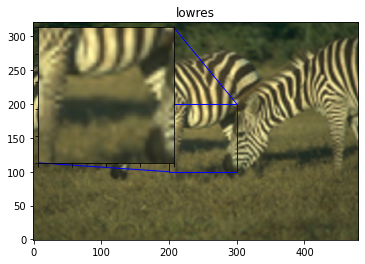

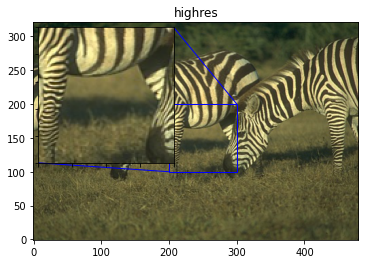

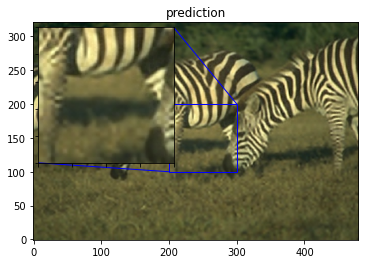

PSNR of low resolution image and high resolution image is 29.8914
PSNR of predict and high resolution is 30.0893


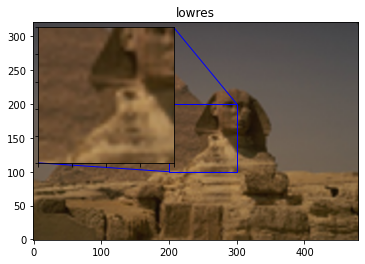

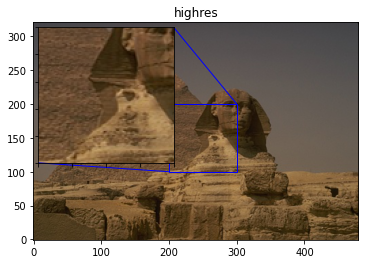

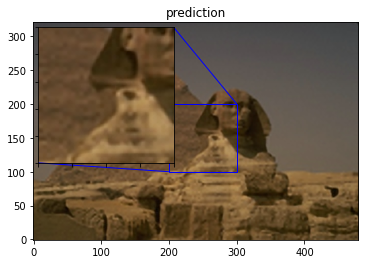

PSNR of low resolution image and high resolution image is 25.1712
PSNR of predict and high resolution is 25.7180


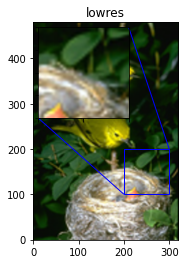

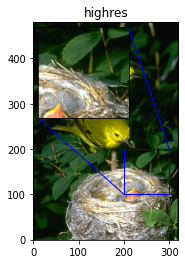

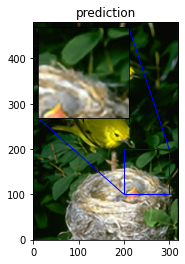

Avg. PSNR of lowres images is 26.6879
Avg. PSNR of reconstructions is 27.3841


In [39]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))